In [76]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

# Sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (
    roc_curve, auc, classification_report, confusion_matrix, accuracy_score
)

# XGBoost
from xgboost import XGBClassifier

# Imbalanced-learn
from imblearn.over_sampling import SMOTE

# Keras imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv1D, MaxPooling1D, LSTM, Dropout, Dense, BatchNormalization
)
from tensorflow.keras.callbacks import EarlyStopping

In [77]:
df = pd.read_csv("database/final-interpolated.csv")

# Drop unnecessary columns (if needed)
df = df.drop(columns=["Unnamed: 0"], errors="ignore")

# Display dataset info
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 975 entries, 0 to 974
Data columns (total 43 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               975 non-null    float64
 1   pH               975 non-null    float64
 2   BDecf            975 non-null    float64
 3   pCO2             975 non-null    float64
 4   BE               975 non-null    float64
 5   Apgar1           975 non-null    float64
 6   Apgar5           975 non-null    float64
 7   Gest. Weeks      975 non-null    float64
 8   Weight(g)        975 non-null    float64
 9   Sex              975 non-null    float64
 10  Age              975 non-null    float64
 11  Gravidity        975 non-null    float64
 12  Parity           975 non-null    float64
 13  Diabetes         975 non-null    float64
 14  Hypertension     975 non-null    float64
 15  Preeclampsia     975 non-null    float64
 16  Liq.             975 non-null    float64
 17  Pyrexia         

# Test Train Split

In [78]:
# Separate Features (X) and Target Variable (y)
X = df.drop(columns=["target"])  # Features
y = df["target"]  # Target (Mode of Delivery)

# Split into Training (80%) and Testing (20%)
# X_train_raw, X_test_raw, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=42, stratify=y
# )
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

def extract_features(df):
    # Example: Select numerical features only
    return df.select_dtypes(include=["int64", "float64"])

# Extract features (custom function, assumed defined earlier)
X_train_feat = extract_features(X_train_raw)
X_test_feat = extract_features(X_test_raw)

# Standardize numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_feat)
X_test_scaled = scaler.transform(X_test_feat)


In [79]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE on the scaled features
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train_raw.reset_index(drop=True))

# Check class distribution after SMOTE
print(y_train_smote.value_counts())

target
0.0    390
1.0    390
Name: count, dtype: int64


# Training Different Models

## Logistic Regression

In [81]:
# 1. Train Logistic Regression
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_smote, y_train_smote)

# 2. Predict
y_pred_lr = lr.predict(X_test_scaled)

# 3. Align y_test just in case
if isinstance(y_test_raw, pd.Series):
    y_test_aligned = y_test_raw.reset_index(drop=True)
else:
    y_test_aligned = y_test_raw

# 4. Evaluate
print("Logistic Regression Results:")
print(classification_report(y_test_aligned, y_pred_lr))

Logistic Regression Results:
              precision    recall  f1-score   support

         0.0       0.87      0.90      0.88        97
         1.0       0.89      0.87      0.88        98

    accuracy                           0.88       195
   macro avg       0.88      0.88      0.88       195
weighted avg       0.88      0.88      0.88       195



In [82]:
print("X_test_scaled shape:", X_test_scaled.shape)
print("y_test shape:", y_test.shape)


X_test_scaled shape: (195, 42)
y_test shape: (203,)


## Support Vector Machine

In [84]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report
svm = SVC(probability=True, random_state=42)
svm.fit(X_train_smote, y_train_smote)
train_pred = svm.predict(X_train_smote)
test_pred = svm.predict(X_test_scaled)
if isinstance(y_test_raw, pd.Series):
    y_test_aligned = y_test_raw.reset_index(drop=True)
else:
    y_test_aligned = y_test_raw
train_acc = accuracy_score(y_train_smote, train_pred)
test_acc = accuracy_score(y_test_aligned, test_pred)
print(f"✅ Training Accuracy: {train_acc:.2f}")
print(f"✅ Test Accuracy: {test_acc:.2f}")
print("SVM Results:")
print(classification_report(y_test_aligned, y_pred_svm))


✅ Training Accuracy: 0.98
✅ Test Accuracy: 0.97
SVM Results:
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97        97
         1.0       1.00      0.95      0.97        98

    accuracy                           0.97       195
   macro avg       0.98      0.97      0.97       195
weighted avg       0.98      0.97      0.97       195



## XGBoost

In [85]:
# Step 1: Initialize XGBoost Classifier
xgb = XGBClassifier(random_state=42, eval_metric='mlogloss', use_label_encoder=False)

# Step 2: Train on SMOTE-applied, scaled training data
xgb.fit(X_train_smote, y_train_smote)

# Step 3: Predict on test data
y_pred_xgb = xgb.predict(X_test_scaled)

# Step 4: Evaluate
print("XGBoost Results:")
print(f"✅ Training Accuracy: {xgb.score(X_train_smote, y_train_smote):.2f}")
print(f"✅ Test Accuracy: {accuracy_score(y_test_aligned, y_pred_xgb):.2f}")
print(classification_report(y_test_aligned, y_pred_xgb))

C:\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:40:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Results:
✅ Training Accuracy: 1.00
✅ Test Accuracy: 0.95
              precision    recall  f1-score   support

         0.0       0.93      0.98      0.95        97
         1.0       0.98      0.93      0.95        98

    accuracy                           0.95       195
   macro avg       0.95      0.95      0.95       195
weighted avg       0.96      0.95      0.95       195



# AUC ROC

In [88]:
# Logistic Regression
y_score_lr = lr.predict_proba(X_test_scaled)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test_aligned, y_score_lr)
auc_lr = auc(fpr_lr, tpr_lr)

# XGBoost
y_score_xgb = xgb.predict_proba(X_test_scaled)[:, 1]
fpr_xgb, tpr_xgb, _ = roc_curve(y_test_aligned, y_score_xgb)
auc_xgb = auc(fpr_xgb, tpr_xgb)

# SVM
y_score_svm = svm.predict_proba(X_test_scaled)[:, 1]
fpr_svm, tpr_svm, _ = roc_curve(y_test_aligned, y_score_svm)
auc_svm = auc(fpr_svm, tpr_svm)

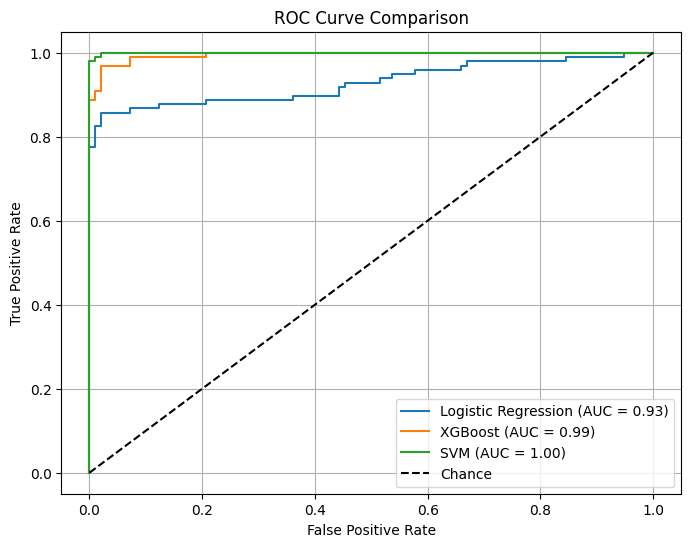

In [89]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_lr:.2f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.2f})')
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {auc_svm:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid(True)
plt.show()

In [90]:
# === Step 1: Load and Encode Labels === #
label_df = pd.read_csv("database/additional_db.csv")
label_df.dropna(subset=['Deliv. type'], inplace=True)

le = LabelEncoder()
label_df['Label'] = le.fit_transform(label_df['Deliv. type'])
label_dict = dict(zip(label_df['ID'].astype(str), label_df['Label']))

print("Label mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

Label mapping: {np.int64(1): np.int64(0), np.int64(2): np.int64(1)}


In [91]:
# === Step 2: Load and Preprocess Time-Series Data === #
data_path = 'database/signals-interpolated/'
MAX_LENGTH = 2400  # Uniform length for LSTM

X_data = []
y_data = []

for file_path in glob.glob(os.path.join(data_path, '*.csv')):
    file_id = os.path.splitext(os.path.basename(file_path))[0]
    if file_id not in label_dict:
        continue

    df = pd.read_csv(file_path)
    if {'FHR', 'UC'}.issubset(df.columns):
        features = df[['FHR', 'UC']].values
    else:
        continue

    # Normalize
    features = (features - np.mean(features, axis=0)) / np.std(features, axis=0)

    # Pad or truncate
    if len(features) > MAX_LENGTH:
        features = features[:MAX_LENGTH]
    else:
        pad = MAX_LENGTH - len(features)
        features = np.pad(features, ((0, pad), (0, 0)), 'constant')

    X_data.append(features)
    y_data.append(label_dict[file_id])

X = np.array(X_data)
y = np.array(y_data)
assert X.shape[1:] == (MAX_LENGTH, 2), f"Shape mismatch: got {X.shape[1:]}"
print("Original class distribution:", Counter(y))

C:\Users\hp\AppData\Local\Temp\ipykernel_26868\2530361159.py:20: RuntimeWarning: invalid value encountered in divide
  features = (features - np.mean(features, axis=0)) / np.std(features, axis=0)
C:\Users\hp\AppData\Local\Temp\ipykernel_26868\2530361159.py:20: RuntimeWarning: invalid value encountered in divide
  features = (features - np.mean(features, axis=0)) / np.std(features, axis=0)


Original class distribution: Counter({np.int64(0): 506, np.int64(1): 46})


In [92]:
# === Step 3: Balance Classes using SMOTE === #
X = np.nan_to_num(X, nan=0.0)
X_flat = X.reshape((X.shape[0], -1))
X_res, y_res = SMOTE(random_state=42, k_neighbors=3).fit_resample(X_flat, y)
X_res = X_res.reshape((-1, MAX_LENGTH, 2))
print(Counter(y))
print("Balanced class distribution:", Counter(y_res))

Counter({np.int64(0): 506, np.int64(1): 46})
Balanced class distribution: Counter({np.int64(0): 506, np.int64(1): 506})


In [101]:
# === Step 4: Train-Test Split === #
# X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42, stratify=y_res)
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)

In [116]:
# === Step 5: CNN-LSTM Model === #
from tensorflow.keras.layers import Bidirectional
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(MAX_LENGTH, 2)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.3),

    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

C:\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)       ┃ Output Shape  ┃ Param # ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ conv1d_7 (Conv1D)  │ (None, 2398,  │     448 │
│                    │ 64)           │         │
├────────────────────┼───────────────┼─────────┤
│ batch_normalizati… │ (None, 2398,  │     256 │
│ (BatchNormalizati… │ 64)           │         │
├────────────────────┼───────────────┼─────────┤
│ max_pooling1d_7    │ (None, 1199,  │       0 │
│ (MaxPooling1D)     │ 64)           │         │
├────────────────────┼───────────────┼─────────┤
│ bidirectional_7    │ (None, 128)   │  66,048 │
│ (Bidirectional)    │               │         │
├────────────────────┼───────────────┼─────────┤
│ dropout_7          │ (None, 128)   │       0 │
│ (Dropout)          │               │         │
├────────────────────┼───────────────┼─────────┤
│ dense_6 (Dense)    │ (None, 1)     │     129 │
└────────────────────┴───────────────┴─────────┘

 Total params: 66,881 (261.25 KB)

 Trainable params: 66,753 (260.75 KB)

 Non-trainable params: 128 (512.00 B)

In [117]:
print(np.unique(y))  # or y_train


[0 1]


In [118]:
# # === Step 6: Train Model === #
# from sklearn.utils.class_weight import compute_class_weight

# class_weights = compute_class_weight(
#     class_weight='balanced',
#     classes=np.unique(y_train),
#     y=y_train
# )
# class_weights = dict(enumerate(class_weights))

# history = model.fit(
#      X_train, y_train,
#     epochs=20,
#     batch_size=32,
#     validation_split=0.2,
#     class_weight=class_weights
# )

import tensorflow as tf
# === Define Early Stopping Callback === #
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# === Compile Model with Extra Metrics === #
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

# === Train the Model === #
history = model.fit(
    X_train_final, y_train_final,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stop]
)


Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.6058 - loss: 0.6500 - precision: 0.5798 - recall: 0.5585 - val_accuracy: 0.6235 - val_loss: 0.6522 - val_precision: 0.5893 - val_recall: 0.8148
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.7610 - loss: 0.5138 - precision: 0.7171 - recall: 0.8702 - val_accuracy: 0.6852 - val_loss: 0.6335 - val_precision: 0.6250 - val_recall: 0.9259
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.8073 - loss: 0.4442 - precision: 0.8080 - recall: 0.7991 - val_accuracy: 0.6914 - val_loss: 0.6104 - val_precision: 0.6240 - val_recall: 0.9630
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.8399 - loss: 0.3837 - precision: 0.8220 - recall: 0.8884 - val_accuracy: 0.7531 - val_loss: 0.5644 - val_precision: 0.6881 - val_recall: 0.9259
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.8365 - loss: 0.4081 - precision: 0.8284 - recall: 0.8605 - val_accuracy: 0.6975 - val_loss: 0.5693 - val

In [119]:
# === Step 7: Evaluation === #
y_pred = (model.predict(X_test) > 0.5).astype(int)
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=['Cesarean', 'Vaginal']))


7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 597ms/step

Classification Report:

              precision    recall  f1-score   support

    Cesarean       0.85      0.75      0.80       102
     Vaginal       0.77      0.87      0.82       101

    accuracy                           0.81       203
   macro avg       0.81      0.81      0.81       203
weighted avg       0.81      0.81      0.81       203



7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 494ms/step


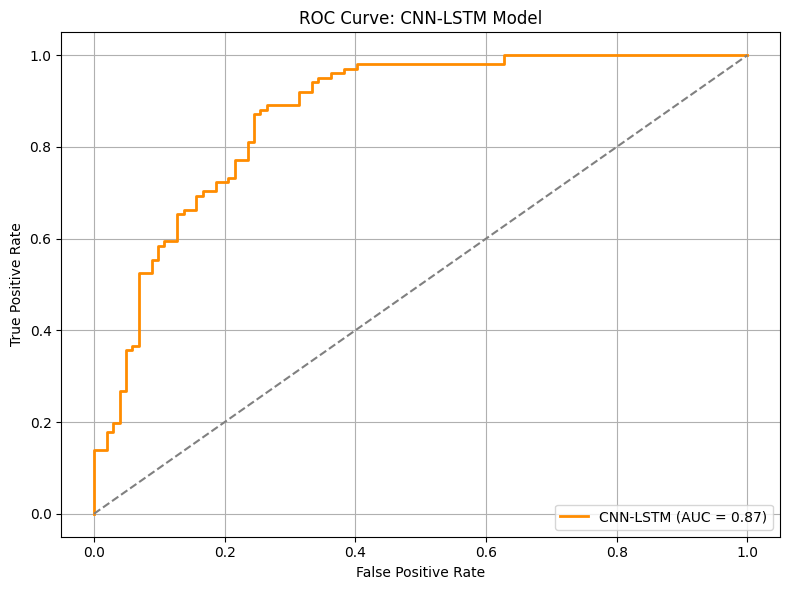

In [120]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# === Predict Probabilities on Test Set === #
y_prob = model.predict(X_test).ravel()  # Flatten predictions
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# === Plot AUC-ROC Curve === #
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'CNN-LSTM (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: CNN-LSTM Model')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [121]:
# STEP 1: Binarize y_test (for binary classification: normal vs cesarean)
y_test_bin = label_binarize(y_test, classes=[0, 1])  # adjust if your classes are [1, 2]
n_classes = y_test_bin.shape[1]


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 492ms/step


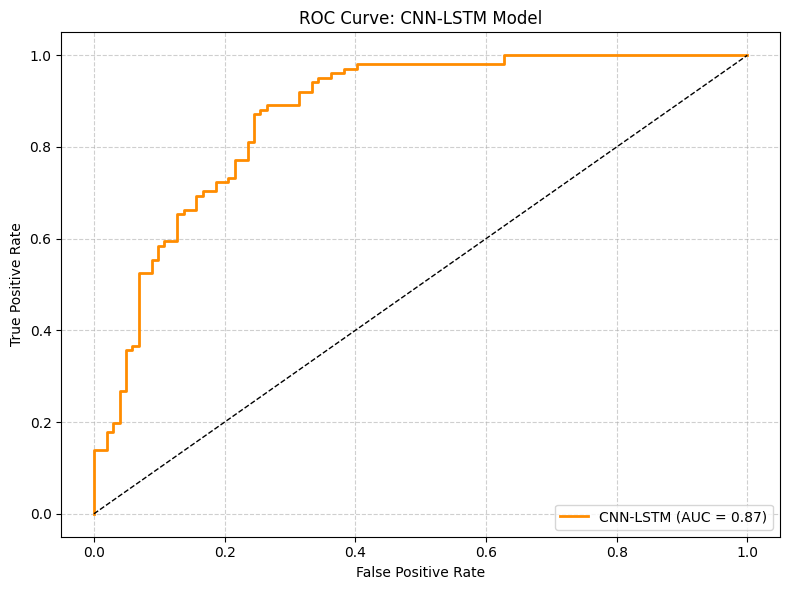

In [122]:
# Predict probabilities on test set
y_pred_dl_prob = model.predict(X_test)

# Flatten if needed
y_pred_dl_prob = y_pred_dl_prob.ravel()

# Binarize the test labels (just in case, and required by roc_curve)
from sklearn.preprocessing import label_binarize
y_test_bin = label_binarize(y_test, classes=[0, 1])  # use your actual label values

# Import ROC/AUC tools
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calculate ROC and AUC
fpr_dl, tpr_dl, _ = roc_curve(y_test_bin, y_pred_dl_prob)
auc_dl = auc(fpr_dl, tpr_dl)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr_dl, tpr_dl, color='darkorange', lw=2, label=f'CNN-LSTM (AUC = {auc_dl:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: CNN-LSTM Model')
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


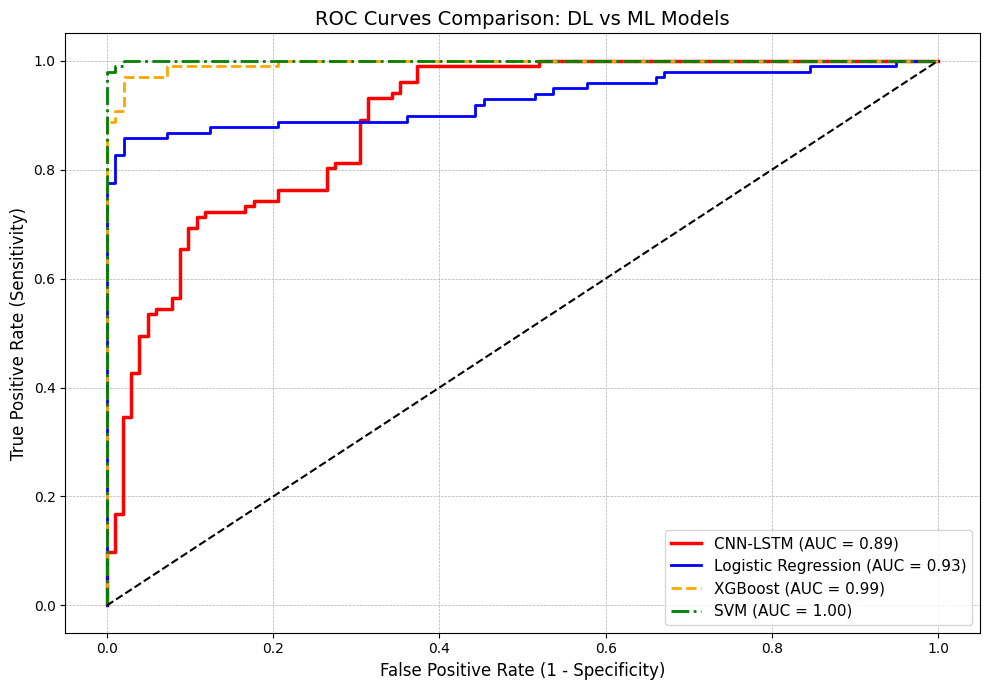

In [66]:
import matplotlib.pyplot as plt

# Plotting all models on the same ROC Curve
plt.figure(figsize=(10, 7))

# CNN-LSTM
plt.plot(fpr_dl, tpr_dl, linestyle='-', color='red', linewidth=2.5, label=f"CNN-LSTM (AUC = {auc_dl:.2f})")

# ML Models
plt.plot(fpr_lr, tpr_lr, linestyle='-', color='blue', linewidth=2, label=f"Logistic Regression (AUC = {auc_lr:.2f})")
plt.plot(fpr_xgb, tpr_xgb, linestyle='--', color='orange', linewidth=2, label=f"XGBoost (AUC = {auc_xgb:.2f})")
plt.plot(fpr_svm, tpr_svm, linestyle='-.', color='green', linewidth=2, label=f"SVM (AUC = {auc_svm:.2f})")

# Random classifier reference line
plt.plot([0, 1], [0, 1], 'k--', lw=1.5)

# Chart Labels
plt.xlabel("False Positive Rate (1 - Specificity)", fontsize=12)
plt.ylabel("True Positive Rate (Sensitivity)", fontsize=12)
plt.title("ROC Curves Comparison: DL vs ML Models", fontsize=14)
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()
